In [ ]:
# Poetry Theme Classification - Comparing Traditional ML & Deep Learning Approaches

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset Shape: (10064, 3)
   Unnamed: 0                                               poem     topic
0           0  Sunday we lay hands\non a girl of ten hand on ...  religion
1           1  O transient voyager of heaven!\n⁠ ⁠ ⁠ O silent...  religion
2           2  \n\n\na cento for Sarah Hegazy\n\n\n\n\na cent...  religion
3           3  I am in the middle of “The Fourteen Poems" by ...  religion
4           4  I lift him out, whole and perfect.\nSaid told ...  religion

Missing values:
Unnamed: 0    0
poem          0
topic         0
dtype: int64


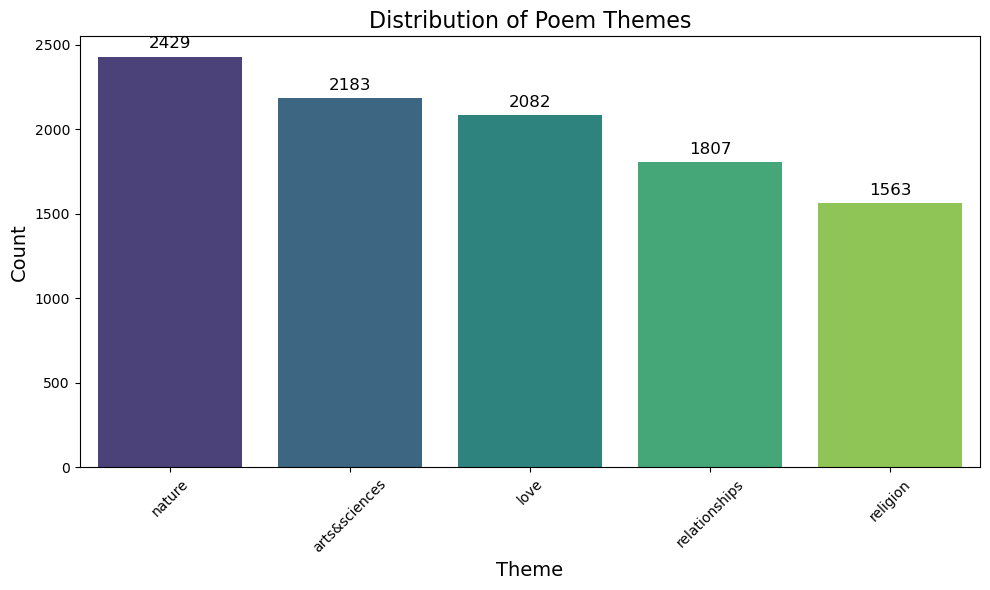

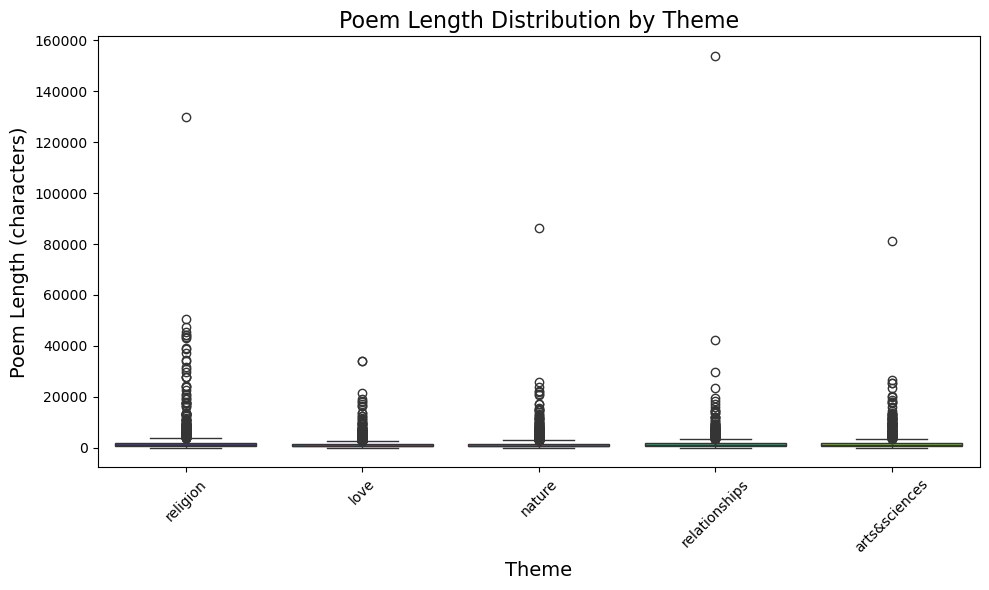

In [15]:
# Load the dataset
df = pd.read_csv('data.csv')  # Replace with your actual file path

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Class distribution
plt.figure(figsize=(10, 6))
theme_counts = df['topic'].value_counts()
sns.barplot(x=theme_counts.index, y=theme_counts.values, palette='viridis')
plt.title('Distribution of Poem Themes', fontsize=16)
plt.xlabel('Theme', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
for i, count in enumerate(theme_counts.values):
    plt.text(i, count + 50, f"{count}", ha='center', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate and visualize average poem length by theme
df['poem_length'] = df['poem'].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic', y='poem_length', data=df, palette='viridis')
plt.title('Poem Length Distribution by Theme', fontsize=16)
plt.xlabel('Theme', fontsize=14)
plt.ylabel('Poem Length (characters)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Preprocessing text data...
Text preprocessing completed.

Sample of processed poems:
Original 1: Sunday we lay hands
on a girl of ten hand on hand on
cornsilk hair. We sing
the secret language sung...
Processed 1: sunday lay hand girl ten hand hand cornsilk hair sing secret language sung day tin roof tower beat g...

Original 2: O transient voyager of heaven!
⁠ ⁠ ⁠ O silent sign of winter skies!
What adverse wind thy sail has d...
Processed 2: transient voyager heaven silent sign winter sky adverse wind thy sail driven dungeon prisoner lie me...

Original 3: 


a cento for Sarah Hegazy




a cento for Sarah Hegazy

a cento for Sarah HegazyIn the hiding
hour...
Processed 3: cento sarah hegazy cento sarah hegazy cento sarah hegazyin hiding hour autophagy ghost hang day talk...



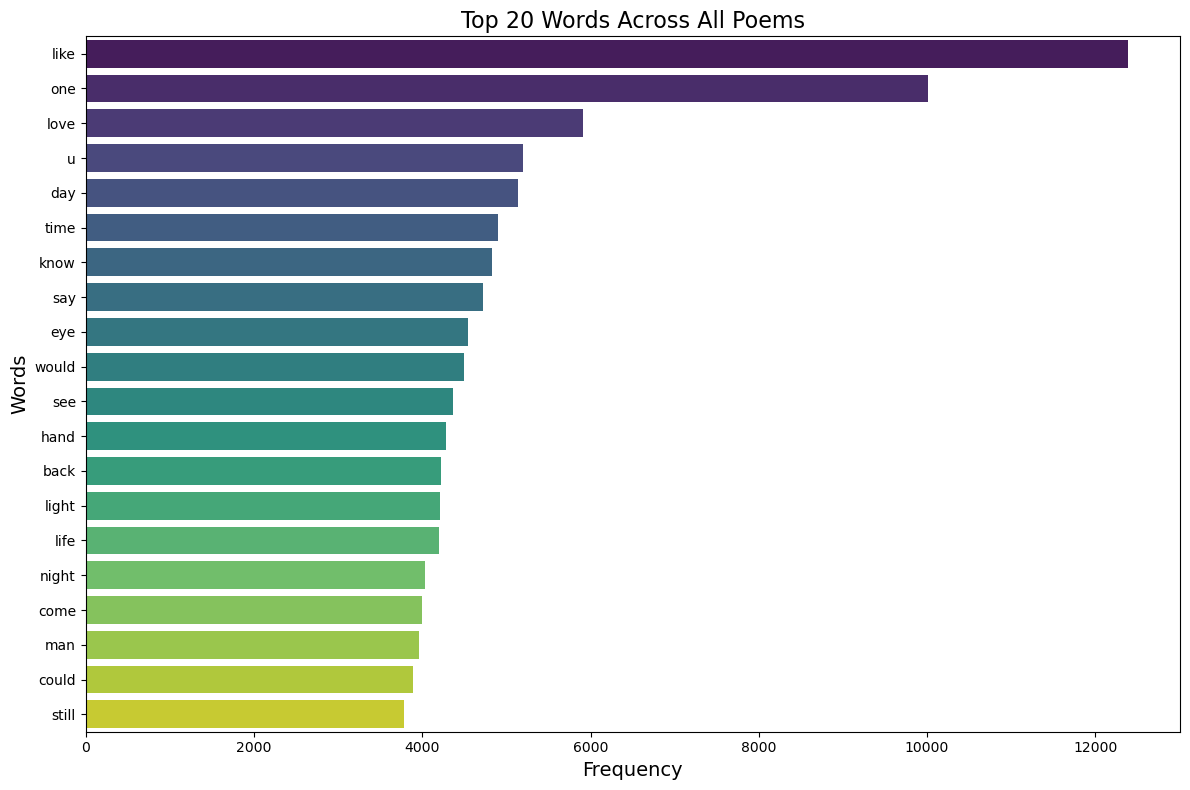

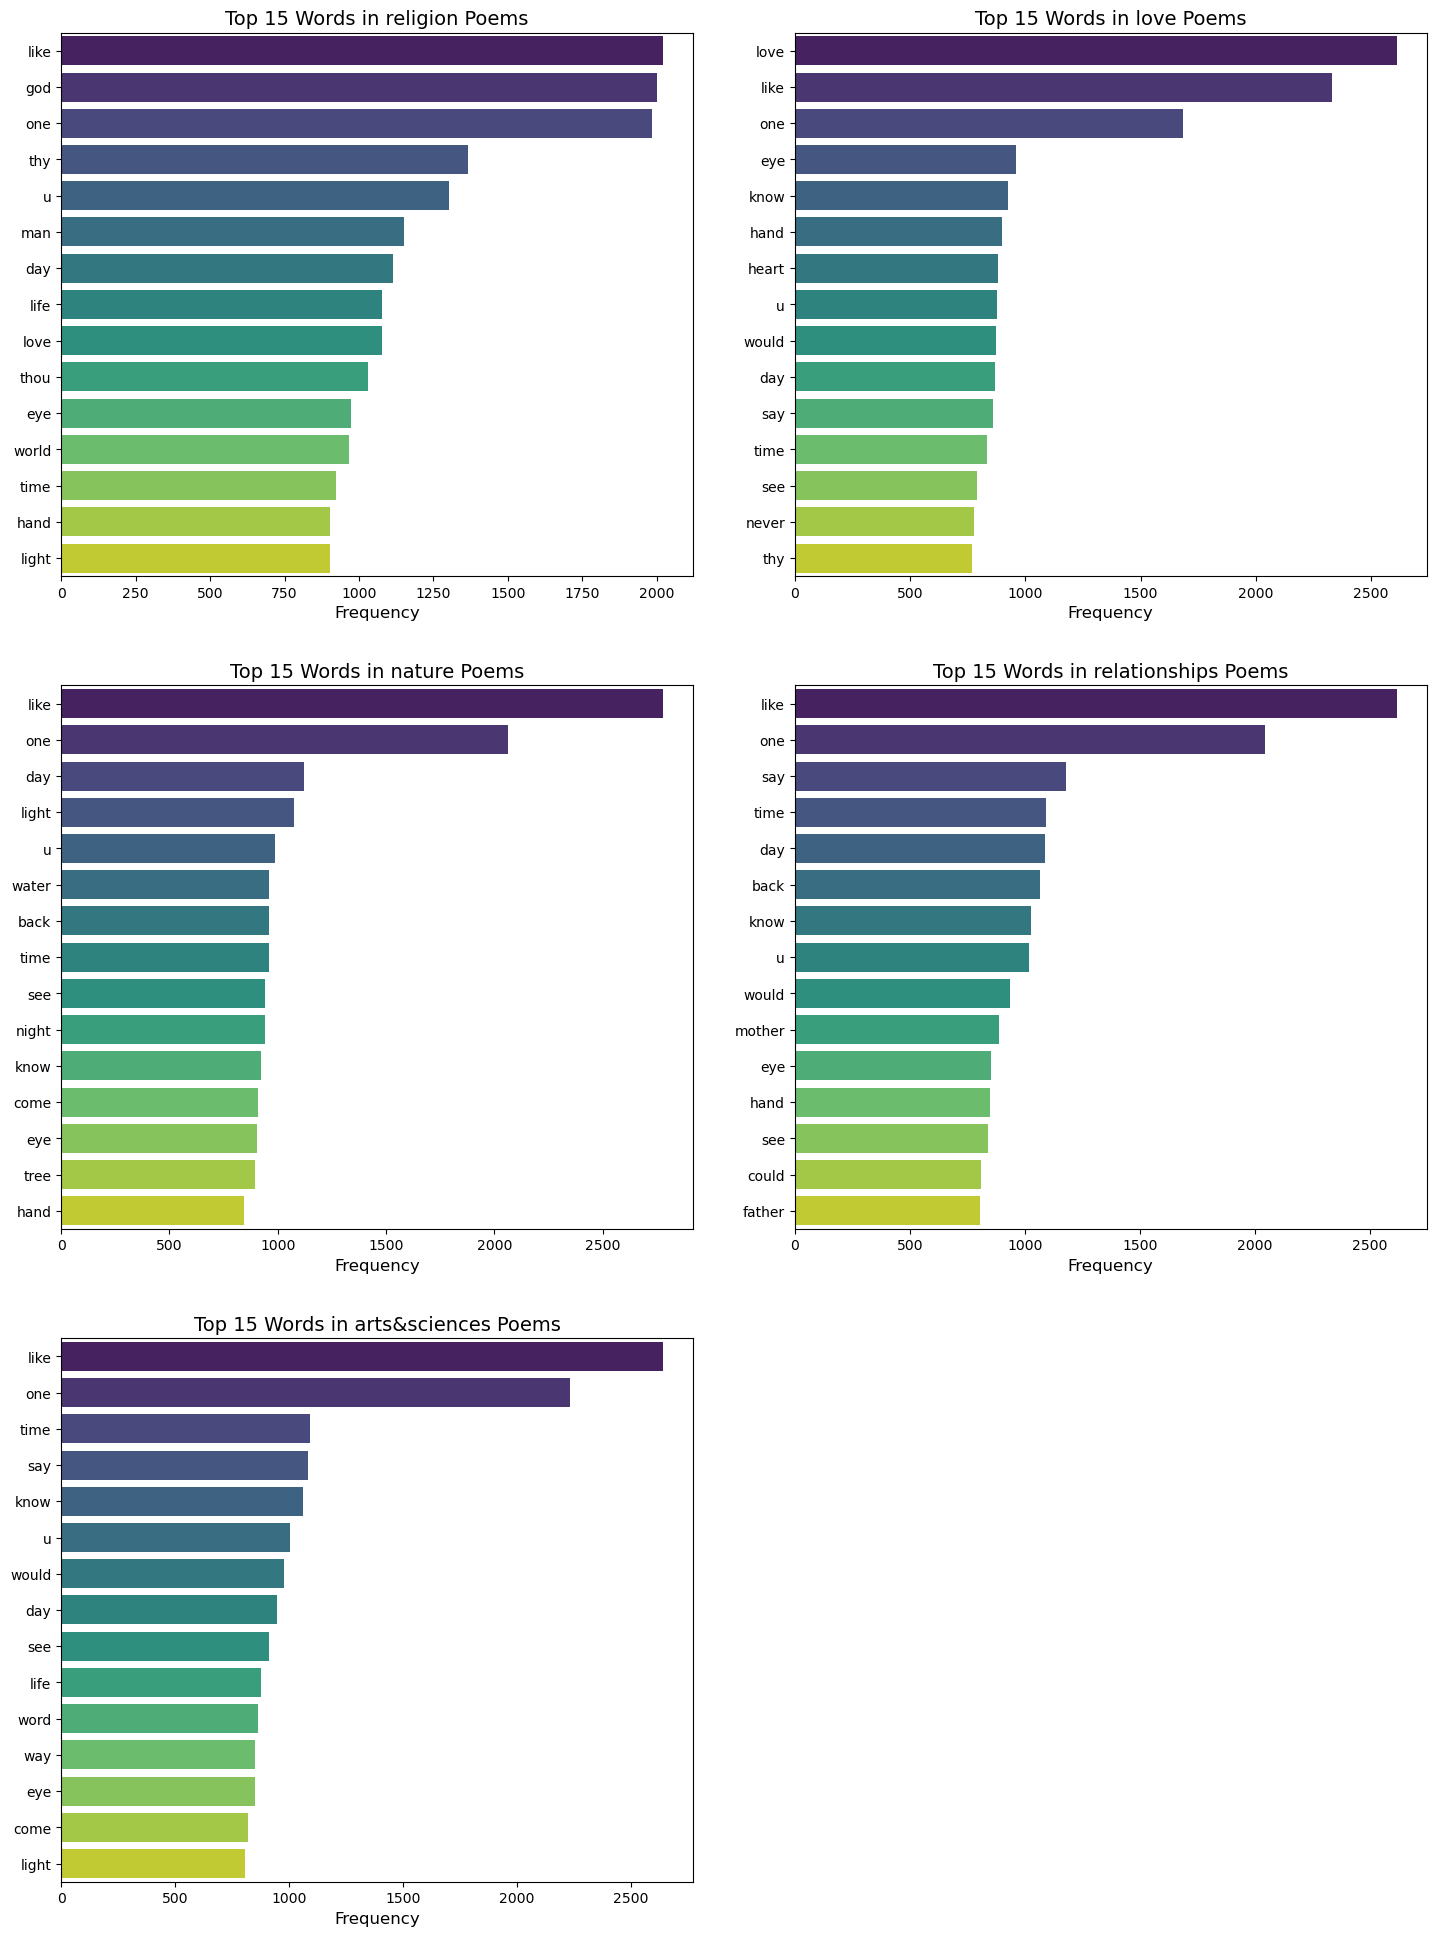

In [16]:
# Text preprocessing function
def preprocess_text(text):
    """
    Function to preprocess the text data:
    1. Convert to lowercase
    2. Remove special characters and extra spaces
    3. Remove punctuation
    4. Remove stopwords
    5. Lemmatize words
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and extra spaces
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Apply preprocessing to the poem column
print("Preprocessing text data...")
df['processed_poem'] = df['poem'].apply(preprocess_text)
print("Text preprocessing completed.")

# Display a sample of processed texts
print("\nSample of processed poems:")
for i, (original, processed) in enumerate(zip(df['poem'].head(3), df['processed_poem'].head(3))):
    print(f"Original {i+1}: {original[:100]}...")
    print(f"Processed {i+1}: {processed[:100]}...")
    print()

# Visualize word frequency
def plot_word_freq(texts, title, top_n=20):
    all_words = ' '.join(texts).split()
    word_freq = Counter(all_words)
    most_common = word_freq.most_common(top_n)
    
    words, counts = zip(*most_common)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_word_freq(df['processed_poem'], 'Top 20 Words Across All Poems')

# Plot word frequency by theme
plt.figure(figsize=(15, 20))
for i, theme in enumerate(df['topic'].unique()):
    plt.subplot(3, 2, i+1)
    theme_poems = df[df['topic'] == theme]['processed_poem']
    all_words = ' '.join(theme_poems).split()
    word_freq = Counter(all_words).most_common(15)
    words, counts = zip(*word_freq)
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f'Top 15 Words in {theme} Poems', fontsize=14)
    plt.xlabel('Frequency', fontsize=12)
    plt.tight_layout()
plt.tight_layout(pad=3.0)
plt.show()

Training set size: 8051
Testing set size: 2013

Class distribution in training set:
topic
nature           1943
arts&sciences    1746
love             1666
relationships    1446
religion         1250
Name: count, dtype: int64

Class distribution in test set:
topic
nature           486
arts&sciences    437
love             416
relationships    361
religion         313
Name: count, dtype: int64

Label mapping: {0: 'arts&sciences', 1: 'love', 2: 'nature', 3: 'relationships', 4: 'religion'}

Creating TF-IDF features...
TF-IDF features shape: (8051, 10000)

Applying SMOTE to balance classes...
Original training set shape: (8051, 10000)
Resampled training set shape: (9715, 10000)

Class distribution after SMOTE:
arts&sciences: 1943
love: 1943
nature: 1943
relationships: 1943
religion: 1943


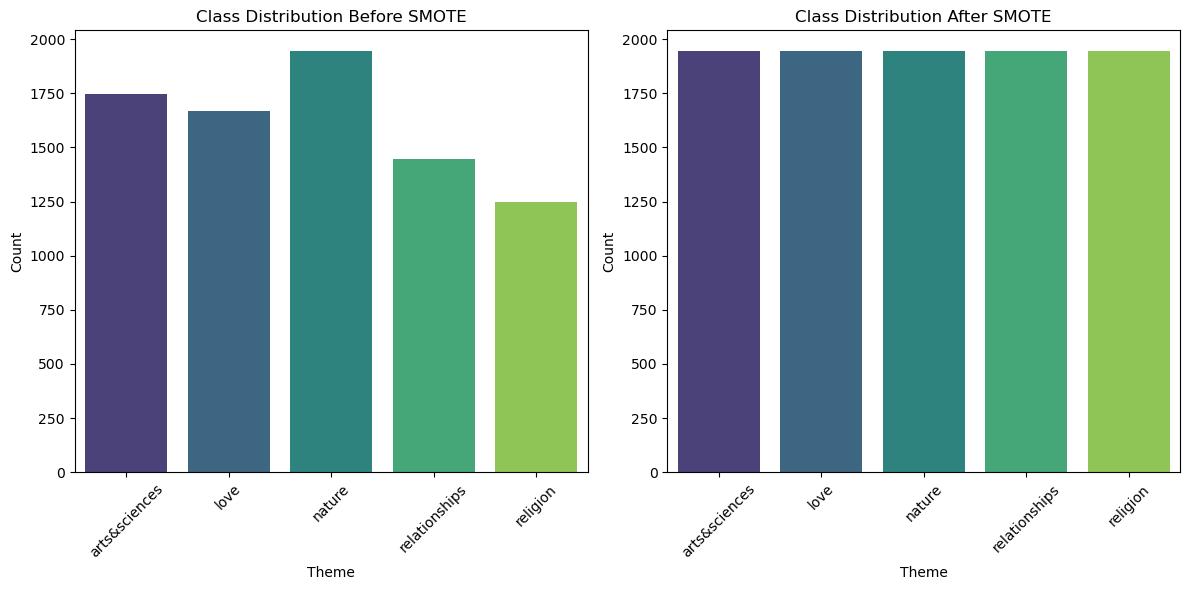

In [17]:
# Data preparation for modeling
X = df['processed_poem']
y = df['topic']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Display class distribution in splits
print("\nClass distribution in training set:")
print(y_train.value_counts())
print("\nClass distribution in test set:")
print(y_test.value_counts())

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Map encoded values to original labels
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print("\nLabel mapping:", label_mapping)

# TF-IDF Feature Engineering
print("\nCreating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"TF-IDF features shape: {X_train_tfidf.shape}")

# SMOTE for handling class imbalance
print("\nApplying SMOTE to balance classes...")
smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_encoded_resampled = smote.fit_resample(X_train_tfidf, y_train_encoded)
print(f"Original training set shape: {X_train_tfidf.shape}")
print(f"Resampled training set shape: {X_train_tfidf_resampled.shape}")

# Check class distribution after SMOTE
unique, counts = np.unique(y_train_encoded_resampled, return_counts=True)
resampled_distribution = dict(zip([label_mapping[cls] for cls in unique], counts))
print("\nClass distribution after SMOTE:")
for cls, count in resampled_distribution.items():
    print(f"{cls}: {count}")

# Visualize class distribution before and after SMOTE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
before_smote = pd.Series(y_train_encoded).value_counts().sort_index()
sns.barplot(x=[label_mapping[i] for i in before_smote.index], y=before_smote.values, palette='viridis')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
after_smote = pd.Series(y_train_encoded_resampled).value_counts().sort_index()
sns.barplot(x=[label_mapping[i] for i in after_smote.index], y=after_smote.values, palette='viridis')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Training SVM model...

SVM Classification Report:
               precision    recall  f1-score   support

arts&sciences       0.47      0.54      0.50       437
         love       0.55      0.50      0.53       416
       nature       0.55      0.56      0.55       486
relationships       0.44      0.43      0.44       361
     religion       0.57      0.50      0.53       313

     accuracy                           0.51      2013
    macro avg       0.51      0.51      0.51      2013
 weighted avg       0.51      0.51      0.51      2013

SVM Accuracy: 0.5112


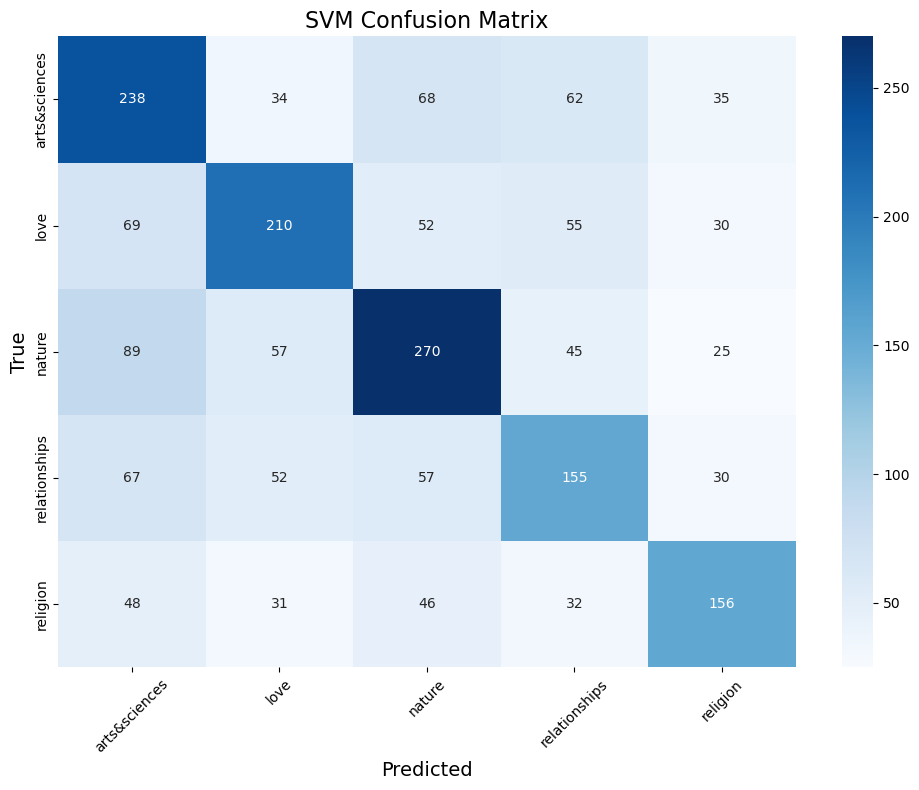


Training Random Forest model...

Random Forest Classification Report:
               precision    recall  f1-score   support

arts&sciences       0.47      0.39      0.43       437
         love       0.53      0.52      0.53       416
       nature       0.46      0.59      0.52       486
relationships       0.42      0.37      0.39       361
     religion       0.46      0.43      0.45       313

     accuracy                           0.47      2013
    macro avg       0.47      0.46      0.46      2013
 weighted avg       0.47      0.47      0.47      2013

Random Forest Accuracy: 0.4699


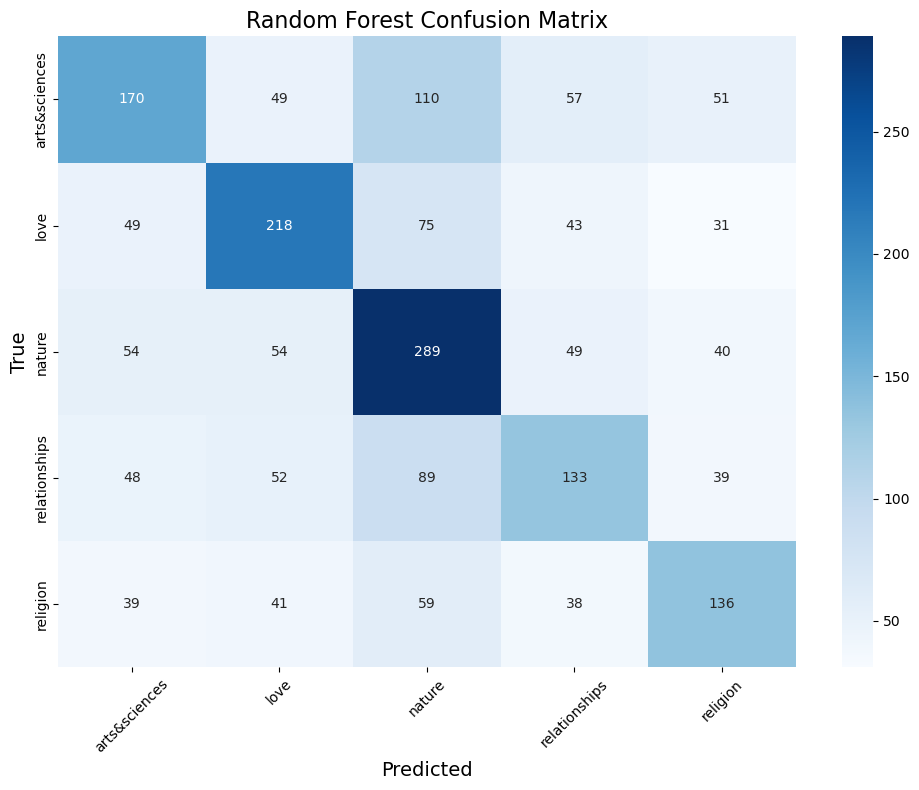

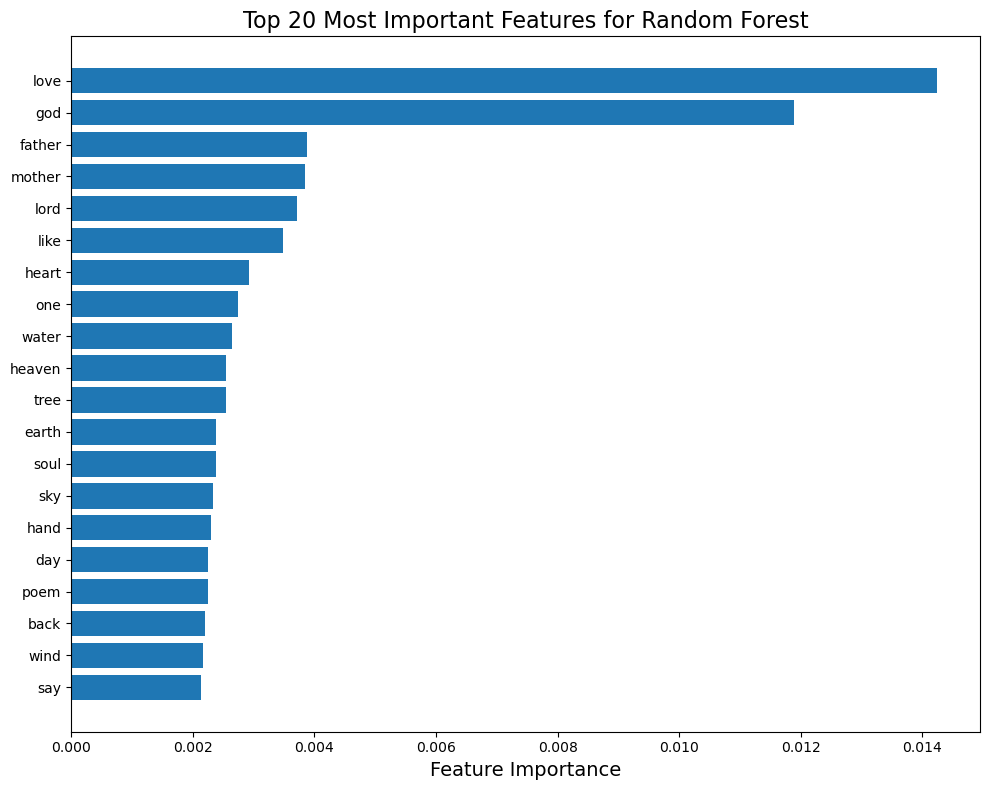


Training One-vs-Rest SVM model for potential multi-label scenarios...

One-vs-Rest SVM Classification Report:
               precision    recall  f1-score   support

arts&sciences       0.48      0.46      0.47       437
         love       0.53      0.53      0.53       416
       nature       0.53      0.54      0.53       486
relationships       0.42      0.40      0.41       361
     religion       0.51      0.55      0.53       313

     accuracy                           0.50      2013
    macro avg       0.49      0.50      0.49      2013
 weighted avg       0.50      0.50      0.50      2013

One-vs-Rest SVM Accuracy: 0.4963


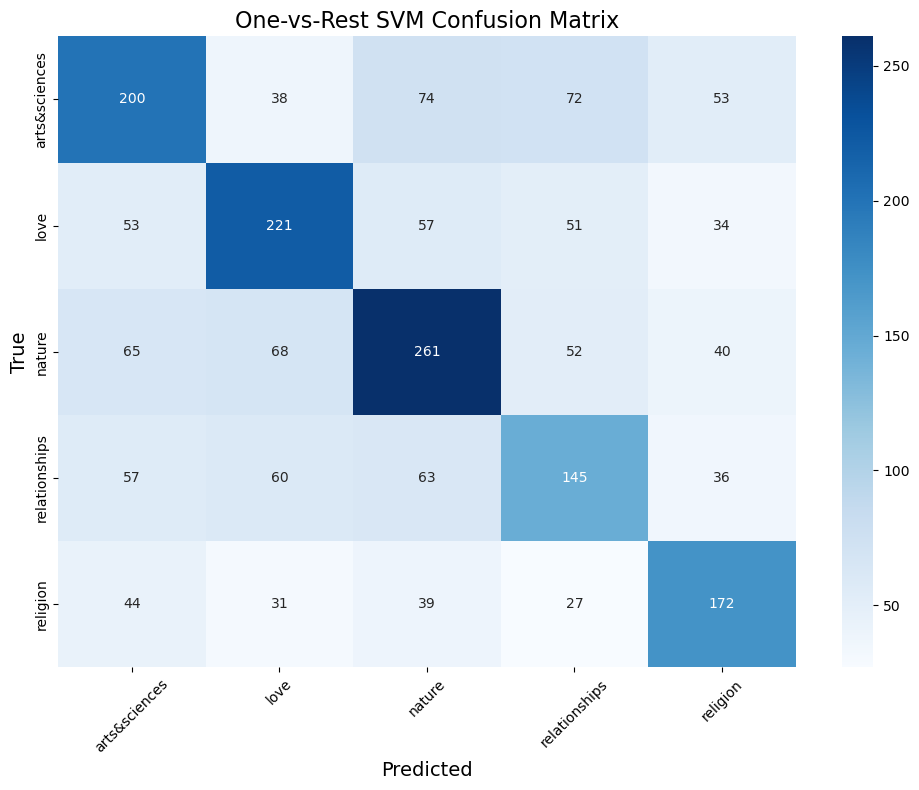

In [6]:
# Function to evaluate and visualize model performance
def evaluate_model(model, X_test, y_test, model_name, label_mapping):
    y_pred = model.predict(X_test)
    
    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=list(label_mapping.values())))
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(label_mapping.values()),
                yticklabels=list(label_mapping.values()))
    plt.title(f'{model_name} Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return accuracy

# 1. Support Vector Machine (SVM)
print("\nTraining SVM model...")
svm_model = SVC(kernel='linear', C=1, probability=True, random_state=42)
svm_model.fit(X_train_tfidf_resampled, y_train_encoded_resampled)
svm_accuracy = evaluate_model(svm_model, X_test_tfidf, y_test_encoded, "SVM", label_mapping)

# 2. Random Forest
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train_tfidf_resampled, y_train_encoded_resampled)
rf_accuracy = evaluate_model(rf_model, X_test_tfidf, y_test_encoded, "Random Forest", label_mapping)

# Feature importance for Random Forest
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]  # Get indices of top 20 features

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Top 20 Most Important Features for Random Forest', fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.tight_layout()
plt.show()

# Multi-label classification model (One-vs-Rest)
print("\nTraining One-vs-Rest SVM model for potential multi-label scenarios...")
ovr_model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))
ovr_model.fit(X_train_tfidf_resampled, y_train_encoded_resampled)
ovr_accuracy = evaluate_model(ovr_model, X_test_tfidf, y_test_encoded, "One-vs-Rest SVM", label_mapping)

In [ ]:
# Preparing data for LSTM
print("\nPreparing data for LSTM model...")

# Tokenize the text
max_features = 10000  # Maximum number of words to keep
maxlen = 200  # Cut texts after this number of words

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

print(f"Padded training data shape: {X_train_pad.shape}")
print(f"Padded test data shape: {X_test_pad.shape}")

# Apply SMOTE to padded sequences
print("\nApplying SMOTE to padded sequences...")
smote = SMOTE(random_state=42)
X_train_pad_resampled, y_train_encoded_resampled_lstm = smote.fit_resample(X_train_pad, y_train_encoded)
print(f"Resampled padded training data shape: {X_train_pad_resampled.shape}")

# Build LSTM model
print("\nBuilding and training LSTM model...")
num_classes = len(label_mapping)

lstm_model = Sequential([
    Embedding(max_features, 128, input_length=maxlen),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(lstm_model.summary())

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = lstm_model.fit(
    X_train_pad_resampled, y_train_encoded_resampled_lstm,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate LSTM model
y_pred_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)

print("\nLSTM Classification Report:")
print(classification_report(y_test_encoded, y_pred_lstm_classes, target_names=list(label_mapping.values())))

lstm_accuracy = accuracy_score(y_test_encoded, y_pred_lstm_classes)
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test_encoded, y_pred_lstm_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()),
            yticklabels=list(label_mapping.values()))
plt.title('LSTM Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Preparing data for LSTM model...
Padded training data shape: (8051, 200)
Padded test data shape: (2013, 200)

Applying SMOTE to padded sequences...


In [24]:
print("\nPreparing data for BERT fine-tuning...")

# Import necessary modules
from transformers import BertTokenizer, BertConfig, TFBertForSequenceClassification
from transformers.optimization_tf import AdamWeightDecay  # Correct import
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping  # Use TensorFlow's built-in Keras

# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to encode text for BERT
def encode_for_bert(texts, max_length=128):
    return bert_tokenizer(
        texts.tolist(),  # Ensure it's a list
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='tf'
    )

# Encode train and test sets
train_encodings = encode_for_bert(X_train)  # Ensure X_train is a list
test_encodings = encode_for_bert(X_test)  # Ensure X_test is a list

# Ensure y_train_encoded and y_test_encoded are NumPy arrays
y_train_encoded = np.array(y_train_encoded)
y_test_encoded = np.array(y_test_encoded)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test_encoded))

# Batch and prepare the datasets
batch_size = 16
train_dataset = train_dataset.shuffle(1000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Build BERT model
print("\nBuilding and fine-tuning BERT model...")

# Define label mapping (Ensure this matches dataset labels)
label_mapping = {0: "Love", 1: "Sadness", 2: "Nature", 3: "Hope"}  

# Define model
bert_config = BertConfig.from_pretrained(
    'bert-base-uncased', 
    num_labels=len(label_mapping)  # Ensure correct label count
)

bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    config=bert_config
)

# Compile model
optimizer = AdamWeightDecay(learning_rate=3e-5, weight_decay_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Fine-tune BERT
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


print("\nFine-tuning BERT (this may take a while)...")
bert_history = bert_model.fit(
    train_dataset,
    epochs=3,  # Reduced for demo
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

# Evaluate BERT model
print("\nEvaluating BERT model...")
bert_eval = bert_model.evaluate(test_dataset)
print(f"BERT Loss: {bert_eval[0]:.4f}")
print(f"BERT Accuracy: {bert_eval[1]:.4f}")

# Get predictions
bert_pred_logits = bert_model.predict(test_dataset).logits  # Fix predict method
bert_pred_classes = tf.argmax(bert_pred_logits, axis=1).numpy()

# Classification report
print("\nBERT Classification Report:")
print(classification_report(y_test_encoded, bert_pred_classes, target_names=list(label_mapping.values())))

# Confusion Matrix for BERT
cm_bert = confusion_matrix(y_test_encoded, bert_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()),
            yticklabels=list(label_mapping.values()))
plt.title('BERT Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Preparing data for BERT fine-tuning...

Building and fine-tuning BERT model...


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fine-tuning BERT (this may take a while)...


AttributeError: 'EarlyStopping' object has no attribute '_implements_train_batch_hooks'

In [ ]:
# Compare all models
print("\nComparing all models...")

# Get accuracies (if BERT was too computationally intensive to run, use a placeholder)
bert_accuracy = bert_eval[1] if 'bert_eval' in locals() else 0.0

# Create model comparison dataframe
models = ['SVM', 'Random Forest', 'OneVsRest SVM', 'LSTM', 'BERT']
accuracies = [svm_accuracy, rf_accuracy, ovr_accuracy, lstm_accuracy, bert_accuracy]

model_comparison = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies
})

# Sort by accuracy
model_comparison = model_comparison.sort_values('Accuracy', ascending=False)

# Plot comparison
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=model_comparison, palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.0)

# Add accuracy values on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                fontsize=12)

plt.tight_layout()
plt.show()

# Radar chart for detailed model comparison per class
# Get F1-scores per class for each model

# Function to get F1-scores per class
def get_f1_scores_per_class(y_true, y_pred, labels, label_names):
    report = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    return [report[name]['f1-score'] for name in label_names]

# Get predictions for each model
y_pred_svm = svm_model.predict(X_test_tfidf)
y_pred_rf = rf_model.predict(X_test_tfidf)
y_pred_ovr = ovr_model.predict(X_test_tfidf)
# LSTM and BERT predictions were calculated earlier

# Get class names
class_names = list(label_mapping.values())

# Get F1-scores per class
f1_svm = get_f1_scores_per_class(y_test_encoded, y_pred_svm, list(label_mapping.keys()), class_names)
f1_rf = get_f1_scores_per_class(y_test_encoded, y_pred_rf, list(label_mapping.keys()), class_names)
f1_ovr = get_f1_scores_per_class(y_test_encoded, y_pred_ovr, list(label_mapping.keys()), class_names)
f1_lstm = get_f1_scores_per_class(y_test_encoded, y_pred_lstm_classes, list(label_mapping.keys()), class_names)
f1_bert = get_f1_scores_per_class(y_test_encoded, bert_pred_classes, list(label_mapping.keys()), class_names)

# Create radar chart
categories = class_names
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Set up plot
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, polar=True)

# Add each model F1-scores
f1_scores = [f1_svm, f1_rf, f1_ovr, f1_lstm, f1_bert]
model_names = ['SVM', 'Random Forest', 'OneVsRest SVM', 'LSTM', 'BERT']
colors = ['blue', 'green', 'red', 'purple', 'brown']

for i, (f1, color, model) in enumerate(zip(f1_scores, colors, model_names)):
    values = f1
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

# Set category labels
plt.xticks(angles[:-1], categories)

# Set y-axis limit
ax.set_ylim(0, 1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('F1-Score by Theme for Each Model', fontsize=16)
plt.tight_layout()
plt.show()

# Final summary and recommendation
print("\n==== Final Summary ====")
print(f"Best performing model: {model_comparison.iloc[0]['Model']} with {model_comparison.iloc[0]['Accuracy']:.4f} accuracy")
print("\nModel strengths by theme:")
for i, theme in enumerate(class_names):
    best_model_idx = np.argmax([f1[i] for f1 in f1_scores])
    print(f"- {theme}: {model_names[best_model_idx]} performs best with F1-score of {f1_scores[best_model_idx][i]:.4f}")

print("\nConclusion:")
print("1. Advanced models like LSTM and BERT tend to perform better overall, especially for capturing subtle poetic nuances.")
print("2. Traditional ML models can be competitive with proper feature engineering and still offer better interpretability.")
print("3. Different models excel at different themes, suggesting an ensemble approach might be optimal.")
print("4. Preprocessing and SMOTE resampling helped address class imbalance issues effectively.")


Comparing all models...


NameError: name 'svm_accuracy' is not defined